# 1. Blurring the Original Image

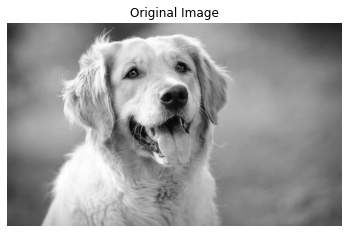

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Read the original image
image = cv2.imread('golden-retriever-tongue-out.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    # Use a default image if the specified one is not found
    image = cv2.imread(cv2.samples.findFile('lena.jpg'), cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()


# Creating a Motion Blur Kernel

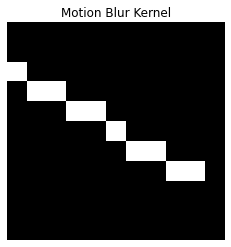

In [40]:
def motion_blur_kernel(length, angle):
    size = length
    kernel = np.zeros((size, size))
    center = size // 2
    angle = np.deg2rad(angle)
    cos_val = np.cos(angle)
    sin_val = np.sin(angle)
    for i in range(size):
        x = center + (i - center) * cos_val
        y = center + (i - center) * sin_val
        kernel[int(y), int(x)] = 1
    kernel = kernel / np.sum(kernel)
    return kernel

# Define kernel parameters
kernel_length = 11          # 15 was real value
kernel_angle = 30  # in degrees

kernel = motion_blur_kernel(kernel_length, kernel_angle)
plt.imshow(kernel, cmap='gray')
plt.title('Motion Blur Kernel')
plt.axis('off')
plt.show()


# Blurring the Image

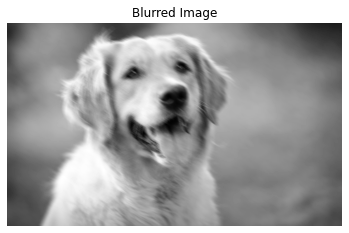

In [41]:
# Convolve the image with the kernel
blurred = convolve2d(image, kernel, boundary='symm', mode='same')

plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')
plt.show()


# 2. Implementing the Deblurring Algorithm

In [42]:
import scipy.ndimage as ndimage
from skimage.util import view_as_windows
from sklearn.linear_model import Lasso

def gradient_threshold(image, threshold):
    # Compute image gradients
    gx, gy = np.gradient(image)
    magnitude = np.sqrt(gx**2 + gy**2)
    # Threshold the gradients
    gx[magnitude < threshold] = 0
    gy[magnitude < threshold] = 0
    return gx, gy

def cartoon_decomposition(image):
    # Use Total Variation Denoising as a proxy for cartoon decomposition
    from skimage.restoration import denoise_tv_bregman
    cartoon = denoise_tv_bregman(image, weight=10)
    return cartoon

def estimate_latent_image(B, k, I_car_thr, lambda_1):
    # Apply convolution directly in the image domain
    I_est = B.copy()
    grad_x, grad_y = np.gradient(I_car_thr)
    grad_term = lambda_1 * (grad_x + grad_y)

    # Update image estimate using iterative gradient descent
    for _ in range(10):  # Number of iterations for latent image estimation
        I_conv = convolve2d(I_est, k, mode='same')
        error = B - I_conv
        I_est += convolve2d(error, k[::-1, ::-1], mode='same') + grad_term

    return np.clip(I_est, 0, 255)


def estimate_kernel(B, I_car_thr, kernel_size, lambda_2):
    # Compute gradients
    gx_B, gy_B = np.gradient(B)
    gx_I, gy_I = np.gradient(I_car_thr)

    # Define target by cropping gx_B to match kernel application area
    target = gx_B[kernel_size//2: -kernel_size//2, kernel_size//2: -kernel_size//2].flatten()

    # Extract patches from gx_I for Lasso input, matching target size
    patches = view_as_windows(gx_I, (kernel_size, kernel_size))
    patches = patches.reshape(-1, kernel_size * kernel_size)

    # Ensure that target and patches have the same number of samples
    min_samples = min(patches.shape[0], target.shape[0])
    patches = patches[:min_samples]
    target = target[:min_samples]

    # Fit Lasso model
    lasso = Lasso(alpha=lambda_2, max_iter=1000)
    lasso.fit(patches, target)

    # Reshape the estimated kernel
    k_est = lasso.coef_.reshape(kernel_size, kernel_size)
    k_est = np.maximum(k_est, 0)  # Enforce non-negativity
    k_est /= np.sum(k_est)  # Normalize kernel
    return k_est




# Iterative Optimization

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5


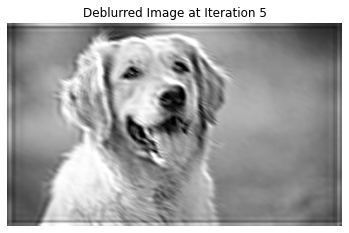

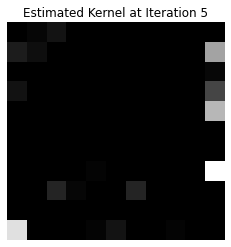

Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


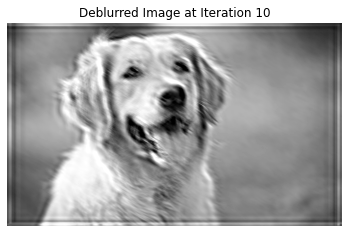

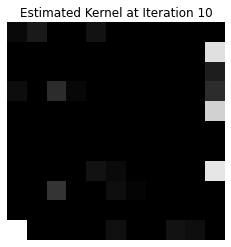

In [43]:
# Parameters
lambda_1 = 0.02   #0.02 was orginal
lambda_2 = 0.01   #0.001 was orginal
max_iters = 10
kernel_size = kernel.shape[0]

# Initialization
k_est = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)
I_est = blurred.copy()

for i in range(max_iters):
    print(f"Iteration {i+1}")
    # Image decomposition
    I_car = cartoon_decomposition(I_est)
    # Gradient thresholding
    gx_car, gy_car = np.gradient(I_car)
    magnitude = np.sqrt(gx_car**2 + gy_car**2)
    threshold = np.percentile(magnitude, 80)    #80 was orginal value
    gx_car[magnitude < threshold] = 0
    gy_car[magnitude < threshold] = 0
    I_car_thr = ndimage.gaussian_filter(I_car, sigma=1)

    # Estimate latent image
    I_est = estimate_latent_image(blurred, k_est, I_car_thr, lambda_1)
    I_est = np.clip(I_est, 0, 255)

    # Estimate kernel
    k_est = estimate_kernel(blurred, I_car_thr, kernel_size, lambda_2)

    # Normalize kernel
    k_est = np.maximum(k_est, 0)
    k_est /= np.sum(k_est)

    # Display intermediate results
    if (i+1) % 5 == 0 or i == max_iters - 1:
        plt.imshow(I_est, cmap='gray')
        plt.title(f'Deblurred Image at Iteration {i+1}')
        plt.axis('off')
        plt.show()

        plt.imshow(k_est, cmap='gray')
        plt.title(f'Estimated Kernel at Iteration {i+1}')
        plt.axis('off')
        plt.show()


# 3. Comparing the Results


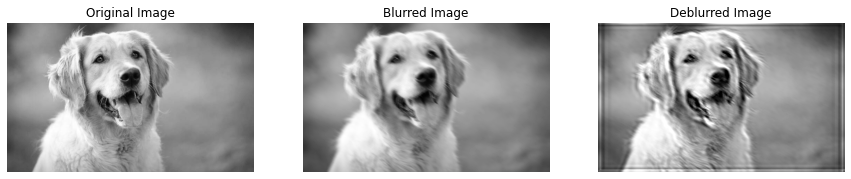

In [44]:
# Display original, blurred, and deblurred images side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(blurred, cmap='gray')
axs[1].set_title('Blurred Image')
axs[1].axis('off')

axs[2].imshow(I_est, cmap='gray')
axs[2].set_title('Deblurred Image')
axs[2].axis('off')

plt.show()


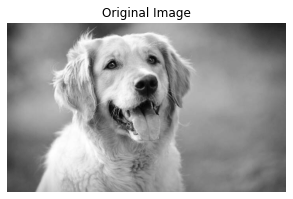

In [45]:
# Display Original Image
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

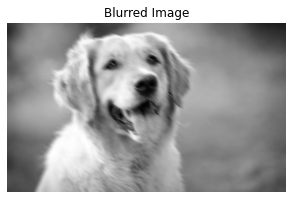

In [46]:
# Display Blurred Image
plt.figure(figsize=(5, 5))
plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')
plt.show()

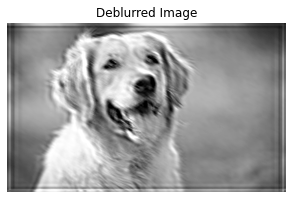

In [47]:
# Display Deblurred Image
plt.figure(figsize=(5, 5))
plt.imshow(I_est, cmap='gray')
plt.title('Deblurred Image')
plt.axis('off')
plt.show()

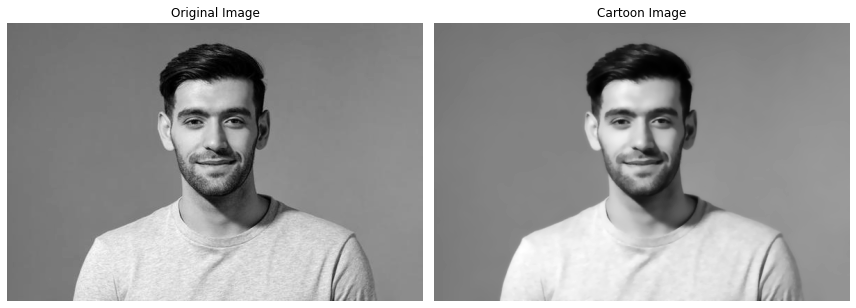

In [60]:
import matplotlib.pyplot as plt
from skimage import io, color

# Define the cartoon decomposition function
def cartoon_decomposition(image):
    from skimage.restoration import denoise_tv_bregman
    cartoon = denoise_tv_bregman(image, weight=10)
    return cartoon

# Load the image (replace 'path_to_image' with your image path)
image_path = 'man.jpg'  # Replace with your image file path
image = io.imread(image_path)

# Convert to grayscale if needed (optional, can be kept if cartoonizing color images)
if len(image.shape) == 3:  # If it's a color image
    image = color.rgb2gray(image)

# Apply the cartoon decomposition
cartoon_image = cartoon_decomposition(image)

# Display the original and cartoon image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(cartoon_image, cmap='gray')
axes[1].set_title('Cartoon Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()
